In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_decision_regions


In [26]:
#!pip install mlxtend
#!pip install griddata

In [27]:
# Load and merge datasets
data = pd.read_csv('data_a.csv', delimiter="\t")

# Display the merged data
#print(data.head())

data


,depth_level,stp_surface,surface_dip,hr,q,a,b,c,status
0,1025,HangingWall,71.538542,3.094170,0.9,1.0,0.21,6.1,Stable
1,1025,FootWall,90.000000,3.103156,1.5,1.0,0.20,8.0,Stable
2,1025,HangingWall,90.000000,2.441781,2.0,1.0,0.29,8.0,Stable
3,1025,FootWall,90.000000,2.419322,2.0,1.0,0.29,8.0,Stable
4,1025,FootWall,90.000000,3.903421,1.5,1.0,0.20,8.0,Stable
...,...,...,...,...,...,...,...,...,...
481,267,FootWall,90.000000,8.840000,2.7,1.0,0.80,8.0,Unstable
482,267,Back,90.000000,3.830000,4.7,1.0,1.00,1.0,Stable
483,267,VerticalEnd,90.000000,3.550000,4.7,1.0,1.00,8.0,Unstable
484,267,HangingWall,90.000000,8.840000,1.6,1.0,0.50,8.0,Unstable


In [1]:
# Exploratory Data Analysis (EDA)
def eda(df):
    print("Data Summary:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nData Types:")
    print(df.dtypes)

    
    # Visualizations
    plt.figure(figsize=(8, 4))
    sns.countplot(x='status', data=df)
    plt.title('Distribution of Status')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='status', y='depth_level', data=df)
    plt.title('Depth Level by Status')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='status', y='surface_dip', data=df)
    plt.title('Surface Dip by Status')
    plt.show()

eda(data)


NameError: name 'data' is not defined

In [29]:
# Data Cleaning
data.dropna(inplace=True)

# Feature Engineering
label_encoders = {}
for column in ['stp_surface', 'status']:
    if column in data.columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le


# Create new feature 'n'
data['n'] = data['q'] * data['a'] * data['b'] * data['c']

# Check for duplicates and drop them
print("Number of duplicates:", data.duplicated().sum())
data = data.drop_duplicates()

data


Number of duplicates: 18


,depth_level,stp_surface,surface_dip,hr,q,a,b,c,status,n
0,1025,2,71.538542,3.094170,0.9,1.0,0.21,6.1,0,1.1529
1,1025,1,90.000000,3.103156,1.5,1.0,0.20,8.0,0,2.4000
2,1025,2,90.000000,2.441781,2.0,1.0,0.29,8.0,0,4.6400
3,1025,1,90.000000,2.419322,2.0,1.0,0.29,8.0,0,4.6400
4,1025,1,90.000000,3.903421,1.5,1.0,0.20,8.0,0,2.4000
...,...,...,...,...,...,...,...,...,...,...
479,267,5,90.000000,2.640000,4.7,1.0,1.00,8.0,0,37.6000
480,267,2,90.000000,8.840000,1.6,1.0,0.50,8.0,1,6.4000
481,267,1,90.000000,8.840000,2.7,1.0,0.80,8.0,1,17.2800
482,267,0,90.000000,3.830000,4.7,1.0,1.00,1.0,0,4.7000


In [ ]:
# Features and target variable
features = ['hr', 'n']
X = data[features]
y = data['status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))



Training set size: 374
Testing set size: 94


In [31]:
# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Base models
base_models = [
    ('gpc', GaussianProcessClassifier()),
    ('svc', SVC(probability=True)),
    ('rfc', RandomForestClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('qda', QuadraticDiscriminantAnalysis()),
    ('lda', LinearDiscriminantAnalysis()),
    ('knc', KNeighborsClassifier()), 
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

In [ ]:
# Function to evaluate each model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Kappa Coefficient: {kappa:.2f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", conf_matrix)

   # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders['status'].classes_, yticklabels=label_encoders['status'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    if X_train.shape[1] > 1:
        plt.figure(figsize=(12, 8))
        try:
            plot_decision_regions(X_train[:, :2], y_train, clf=model, legend=2)
            plt.title(f'Decision Regions for {model.__class__.__name__} (Hydraulic Radius vs Stability Number)')
            plt.xlabel('hr')
            plt.ylabel('surface_dip')
            plt.show()
        except Exception as e:
            print(f"Error plotting decision regions for {model.__class__.__name__}: {e}")

# Evaluate each base model
     # Plot isoprobability contours for a subset of features (e.g., hr and n)
    if hasattr(model, "predict_proba"):
        try:
            # Create a grid for contouring
            hr_min, hr_max = X_train[:, 0].min(), X_train[:, 0].max()
            n_min, n_max = X_train[:, 1].min(), X_train[:, 1].max()
            
            grid_hr, grid_n = np.meshgrid(np.linspace(hr_min, hr_max, 100),
                                          np.linspace(n_min, n_max, 100))
            
            # Flatten grid and scale
            grid_points = np.c_[grid_hr.ravel(), grid_n.ravel()]
            grid_points_scaled = scaler.transform(grid_points)
            
            # Predict probabilities on the grid
            grid_probs = model.predict_proba(grid_points_scaled)[:, 1].reshape(grid_hr.shape)
            
            # Plot isoprobability contours
            plt.figure(figsize=(8, 6))
            contour = plt.contourf(grid_hr, grid_n, grid_probs, levels=np.linspace(0, 1, 11), cmap="coolwarm")
            plt.colorbar(label="Probability of Instability")
            
            # Scatter plot of original data points
            plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors='black', marker='o')
            plt.xlabel("HR (Hydraulic Radius)")
            plt.ylabel("N (Stability Number)")
            plt.title(f"Isoprobability Contour of Stope Stability for {model.__class__.__name__}")
            plt.show()
        except Exception as e:
            print(f"Error plotting isoprobability contours for {model.__class__.__name__}: {e}")

Model: GaussianProcessClassifier
Accuracy: 0.72
Kappa Coefficient: 0.43

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76        53
           1       0.70      0.63      0.67        41

    accuracy                           0.72        94
   macro avg       0.72      0.71      0.72        94
weighted avg       0.72      0.72      0.72        94


Confusion Matrix:
 [[42 11]
 [15 26]]


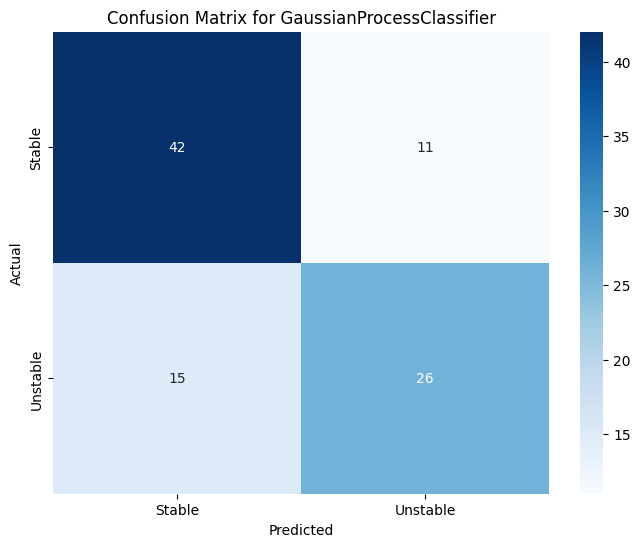

Error plotting decision regions for GaussianProcessClassifier: Unable to allocate 2.68 GiB for an array with shape (374, 960000) and data type float64


C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


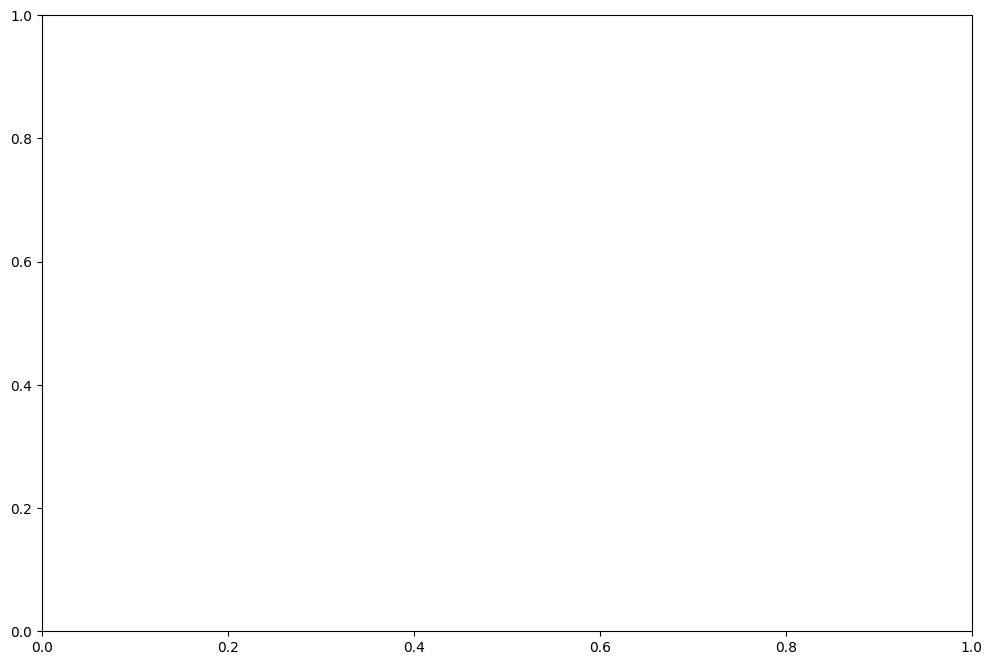

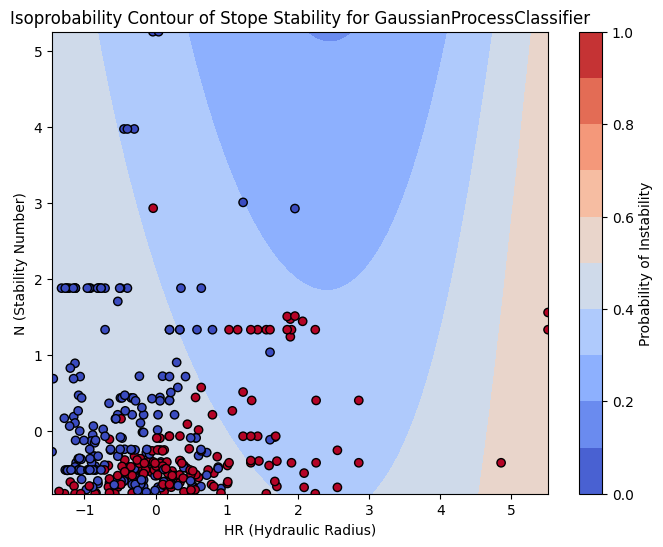

Model: SVC
Accuracy: 0.73
Kappa Coefficient: 0.45

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78        53
           1       0.74      0.61      0.67        41

    accuracy                           0.73        94
   macro avg       0.73      0.72      0.72        94
weighted avg       0.73      0.73      0.73        94


Confusion Matrix:
 [[44  9]
 [16 25]]


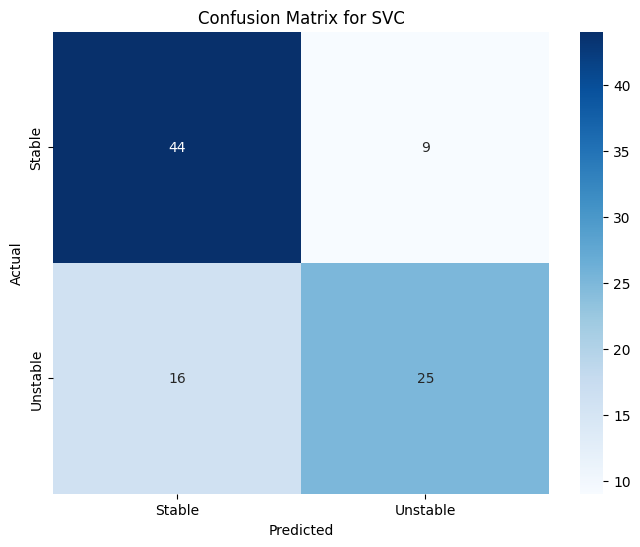

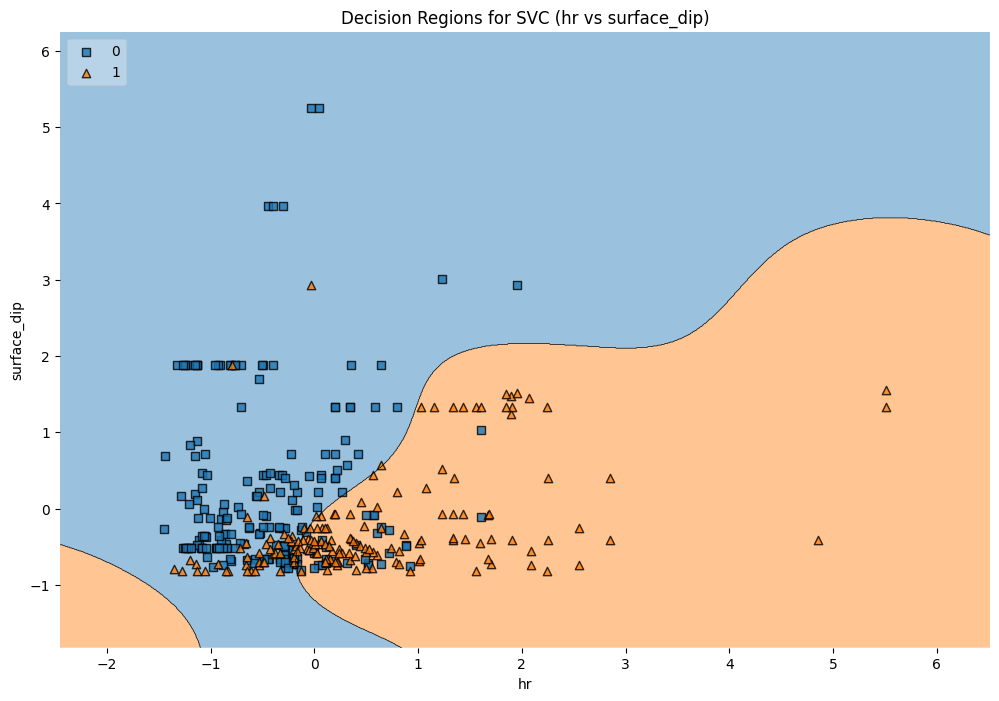

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


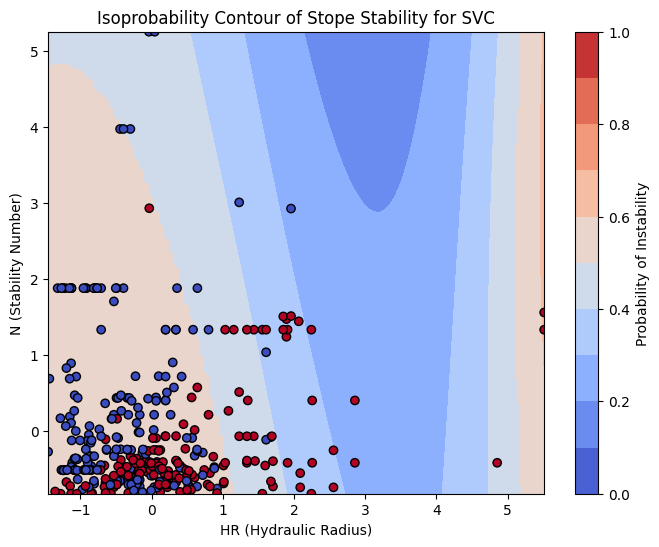

Model: RandomForestClassifier
Accuracy: 0.84
Kappa Coefficient: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        53
           1       0.78      0.88      0.83        41

    accuracy                           0.84        94
   macro avg       0.84      0.84      0.84        94
weighted avg       0.85      0.84      0.84        94


Confusion Matrix:
 [[43 10]
 [ 5 36]]


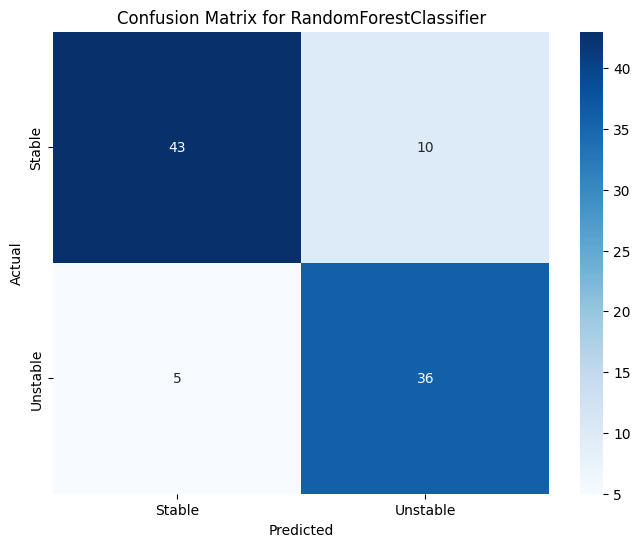

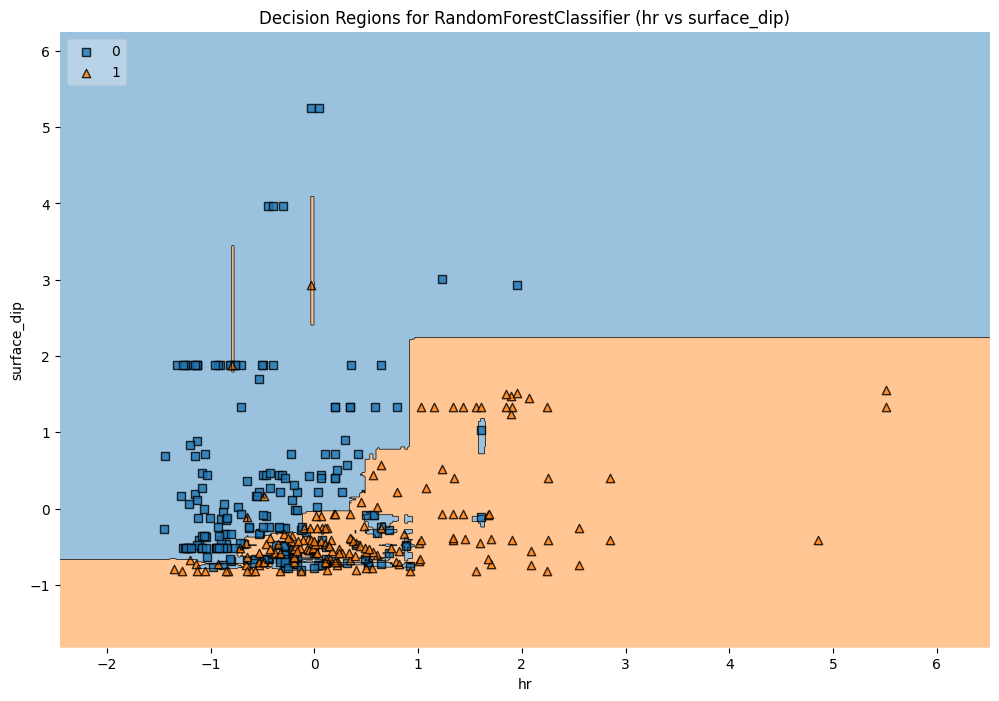

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


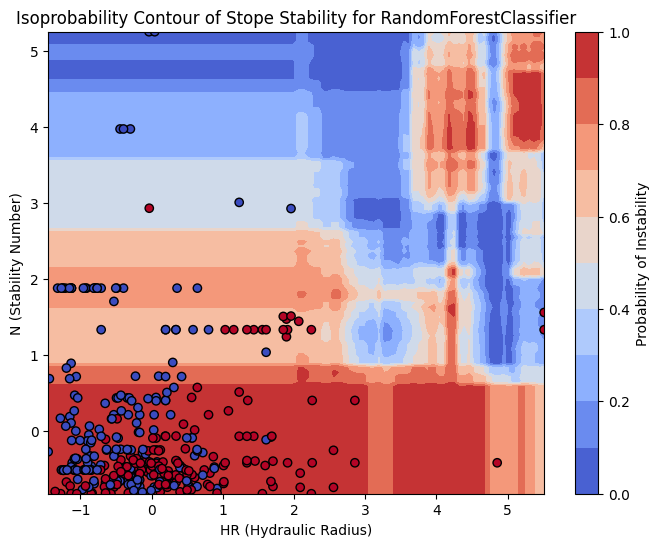

Model: GradientBoostingClassifier
Accuracy: 0.80
Kappa Coefficient: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82        53
           1       0.76      0.78      0.77        41

    accuracy                           0.80        94
   macro avg       0.79      0.80      0.80        94
weighted avg       0.80      0.80      0.80        94


Confusion Matrix:
 [[43 10]
 [ 9 32]]


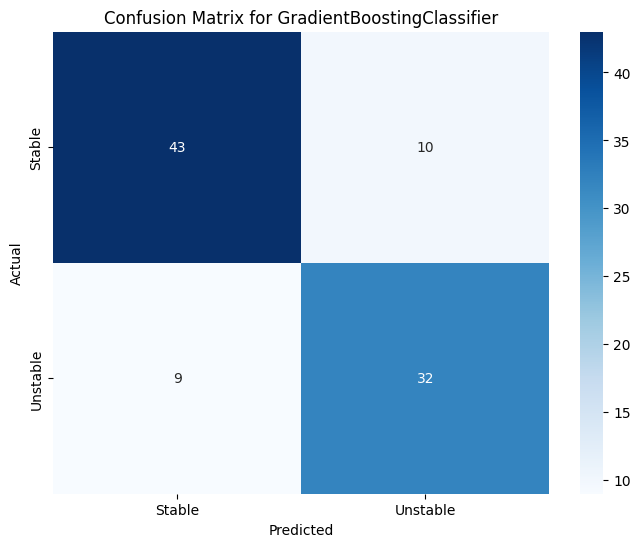

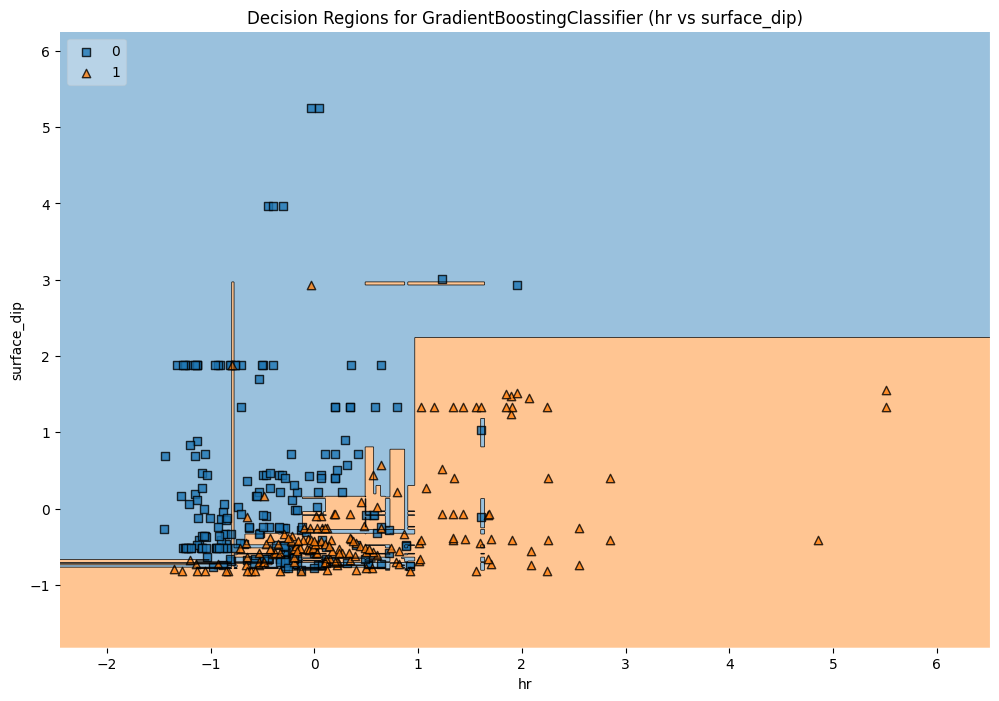

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


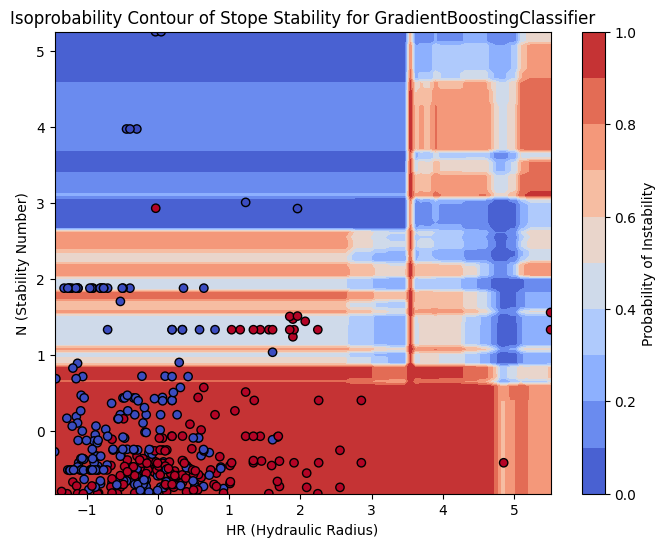

Model: QuadraticDiscriminantAnalysis
Accuracy: 0.72
Kappa Coefficient: 0.42

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77        53
           1       0.73      0.59      0.65        41

    accuracy                           0.72        94
   macro avg       0.72      0.71      0.71        94
weighted avg       0.72      0.72      0.72        94


Confusion Matrix:
 [[44  9]
 [17 24]]


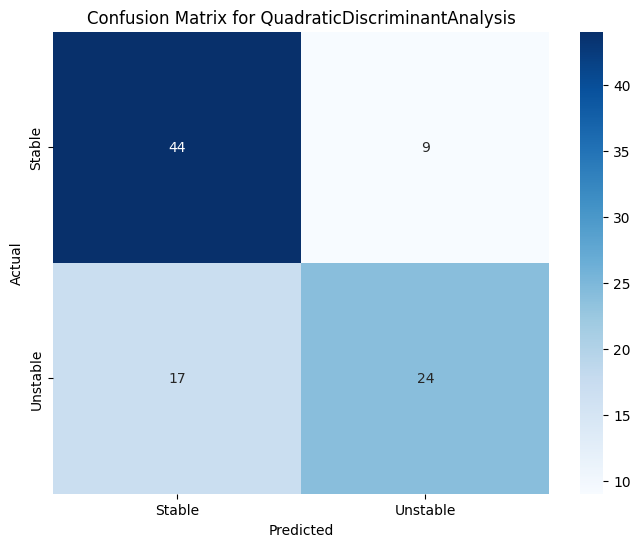

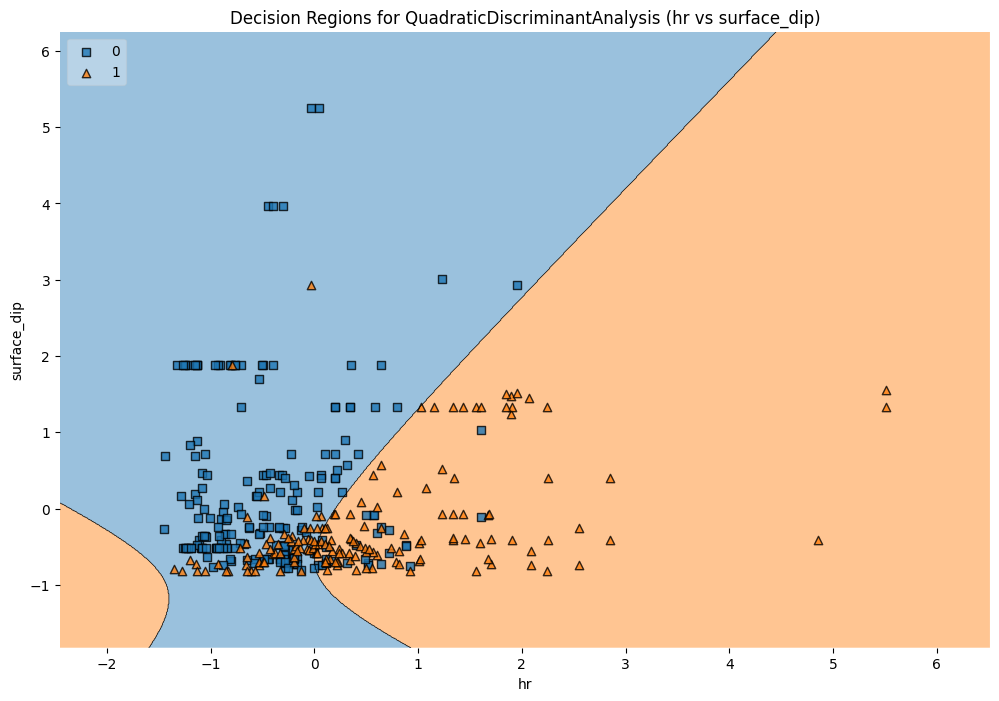

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


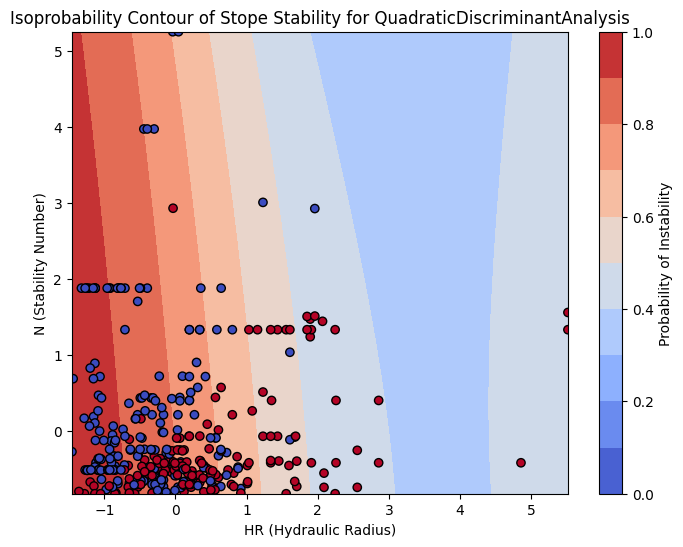

Model: LinearDiscriminantAnalysis
Accuracy: 0.72
Kappa Coefficient: 0.42

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77        53
           1       0.73      0.59      0.65        41

    accuracy                           0.72        94
   macro avg       0.72      0.71      0.71        94
weighted avg       0.72      0.72      0.72        94


Confusion Matrix:
 [[44  9]
 [17 24]]


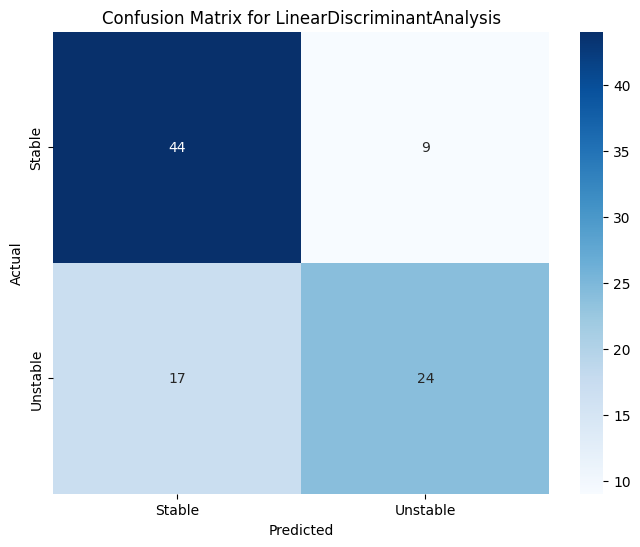

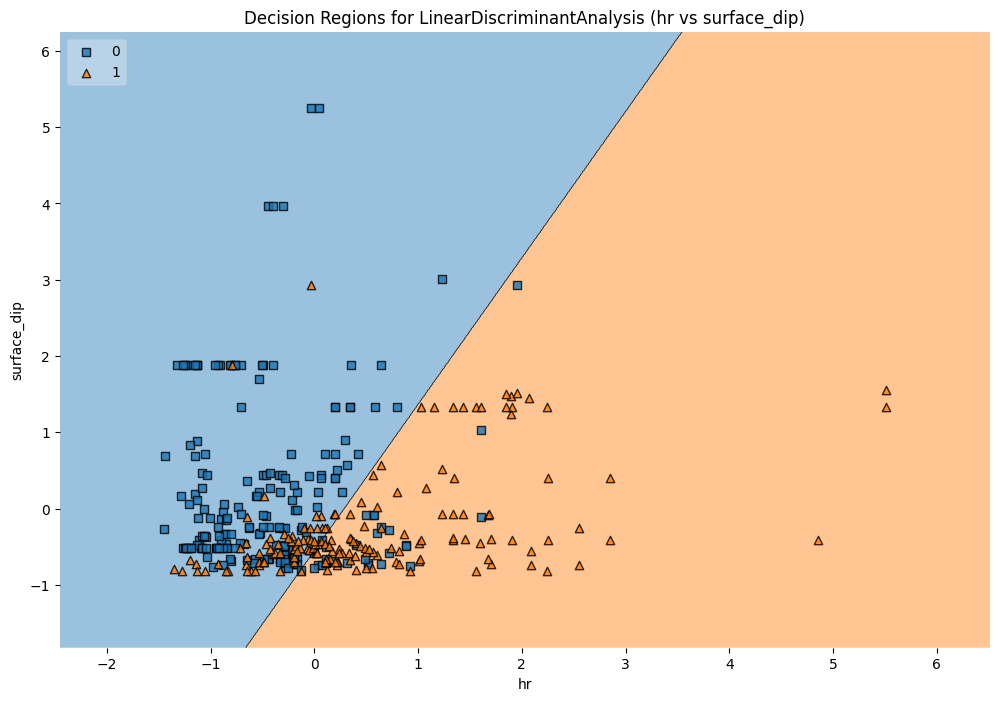

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


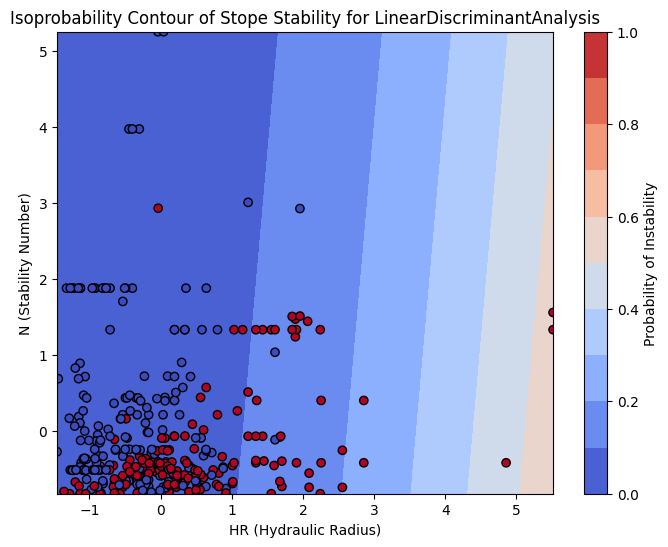

Model: KNeighborsClassifier
Accuracy: 0.83
Kappa Coefficient: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        53
           1       0.82      0.78      0.80        41

    accuracy                           0.83        94
   macro avg       0.83      0.82      0.83        94
weighted avg       0.83      0.83      0.83        94


Confusion Matrix:
 [[46  7]
 [ 9 32]]


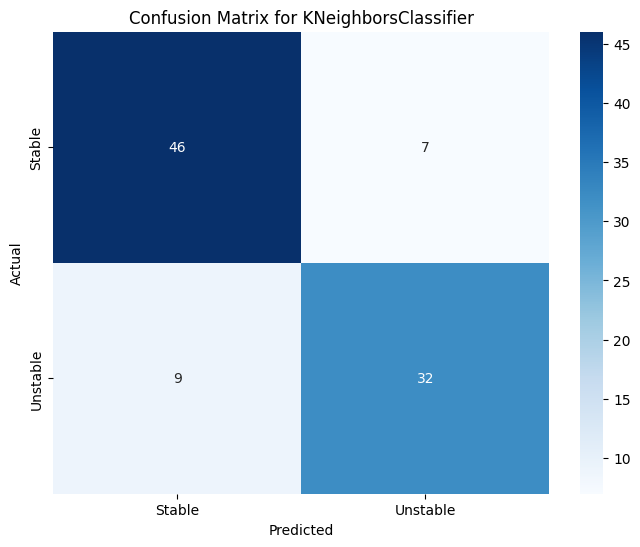

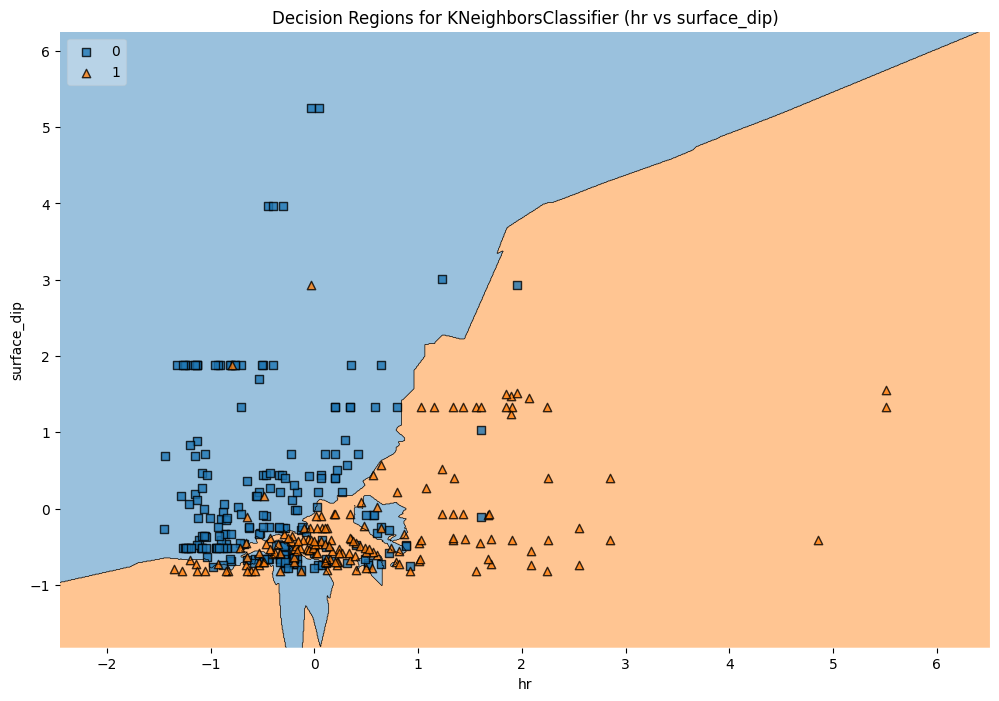

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


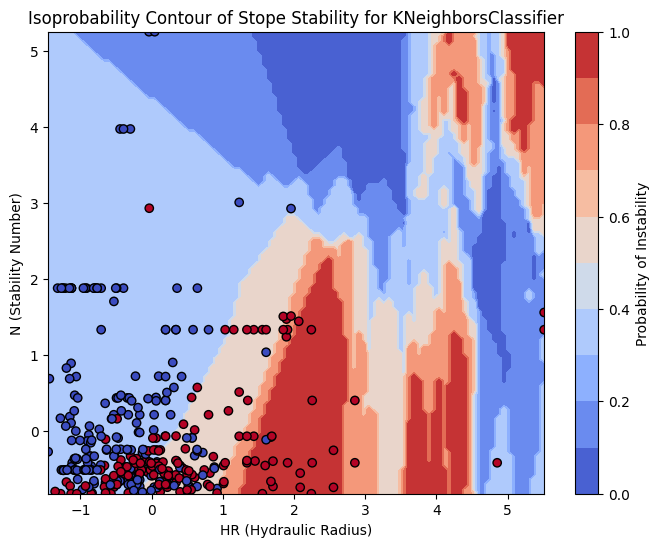

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBClassifier
Accuracy: 0.81
Kappa Coefficient: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82        53
           1       0.74      0.85      0.80        41

    accuracy                           0.81        94
   macro avg       0.81      0.81      0.81        94
weighted avg       0.82      0.81      0.81        94


Confusion Matrix:
 [[41 12]
 [ 6 35]]


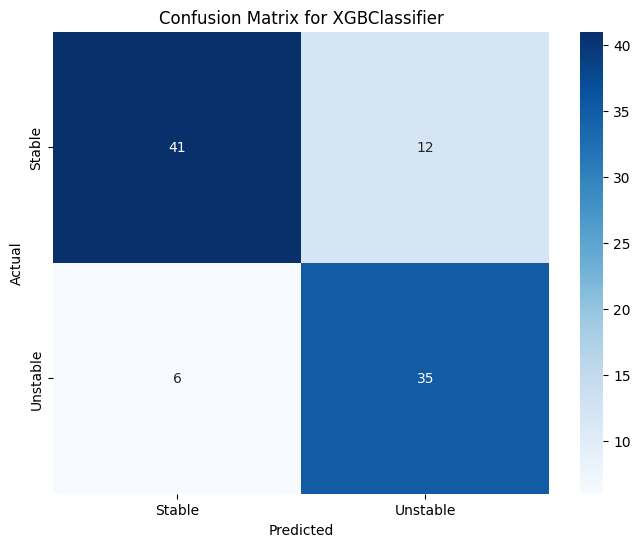

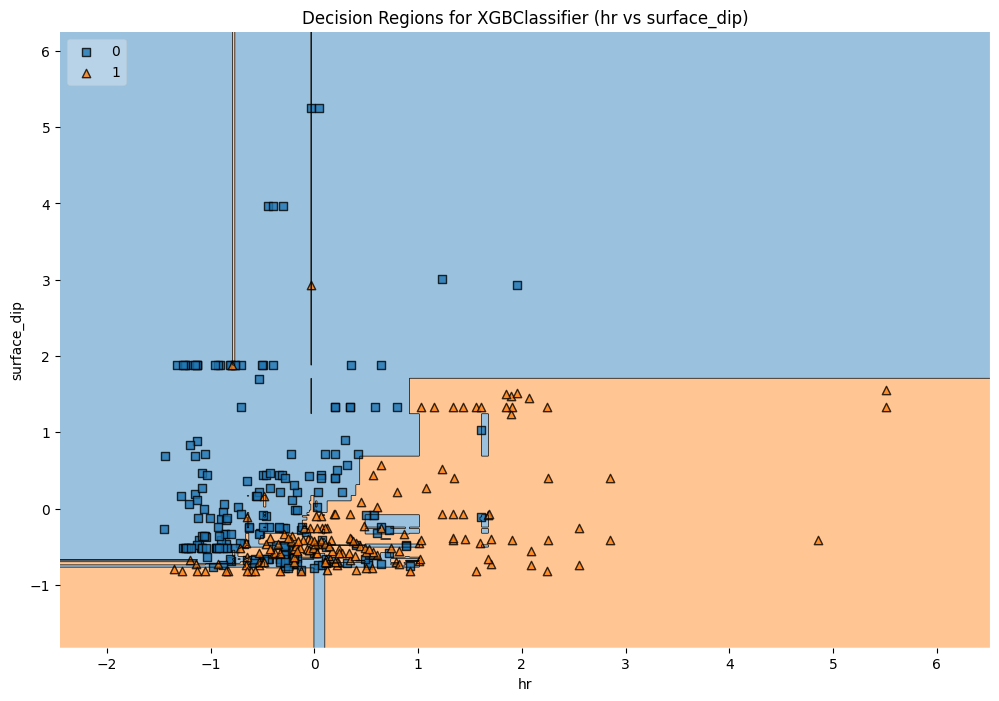

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


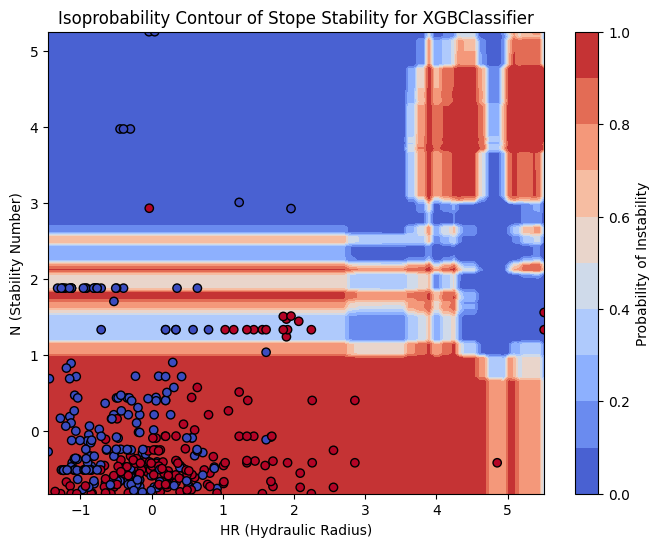

In [33]:
# Evaluate each base model
for name, model in base_models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

In [ ]:
meta_model = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

In [35]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'gpc__max_iter_predict': [100, 200],
    'svc__C': [0.1, 1, 10],
    'rfc__n_estimators': [50, 100],
    'gbc__n_estimators': [50, 100],
    'knc__n_neighbors': [3, 5],
    'xgb__n_estimators': [50, 100]
}

grid_search = GridSearchCV(stacking_clf, param_grid, cv=5, scoring='accuracy')  # Use f1_weighted for imbalanced datasets
grid_search.fit(X_train, y_train)

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('gpc',
                                                       GaussianProcessClassifier()),
                                                      ('svc',
                                                       SVC(probability=True)),
                                                      ('rfc',
                                                       RandomForestClassifier()),
                                                      ('gbc',
                                                       GradientBoostingClassifier()),
                                                      ('qda',
                                                       QuadraticDiscriminantAnalysis()),
                                                      ('lda',
                                                       LinearDiscriminantAnalysis()),
                                                      ('knc',
                                                       KNeighborsClassifier()),
                                                      ('xgb',
                                                       XGBClassifier(base_score=None,
                                                                     boost...
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     random_state=None, ...))],
                                          final_estimator=LogisticRegression()),
             param_grid={'gbc__n_estimators': [50, 100],
                         'gpc__max_iter_predict': [100, 200],
                         'knc__n_neighbors': [3, 5],
                         'rfc__n_estimators': [50, 100], 'svc__C': [0.1, 1, 10],
                         'xgb__n_estimators': [50, 100]},
             scoring='accuracy')

In [36]:
# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Predictions on test set
y_pred = grid_search.predict(X_test)

Best parameters found:  {'gbc__n_estimators': 100, 'gpc__max_iter_predict': 100, 'knc__n_neighbors': 3, 'rfc__n_estimators': 50, 'svc__C': 0.1, 'xgb__n_estimators': 50}
Best cross-validation score: 0.85


Test set accuracy: 0.84
Kappa Coefficient: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        53
           1       0.82      0.80      0.81        41

    accuracy                           0.84        94
   macro avg       0.84      0.84      0.84        94
weighted avg       0.84      0.84      0.84        94



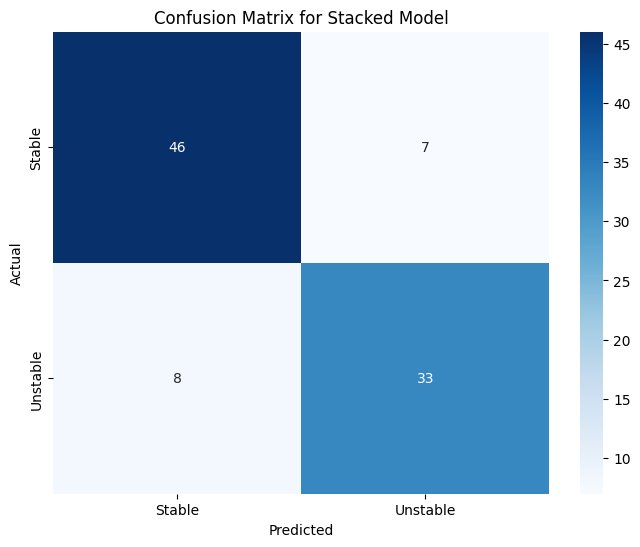

In [37]:
# Model Evaluation
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Kappa Coefficient: {:.2f}".format(cohen_kappa_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix for Stacked Model
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders['status'].classes_, yticklabels=label_encoders['status'].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stacked Model')
plt.show()

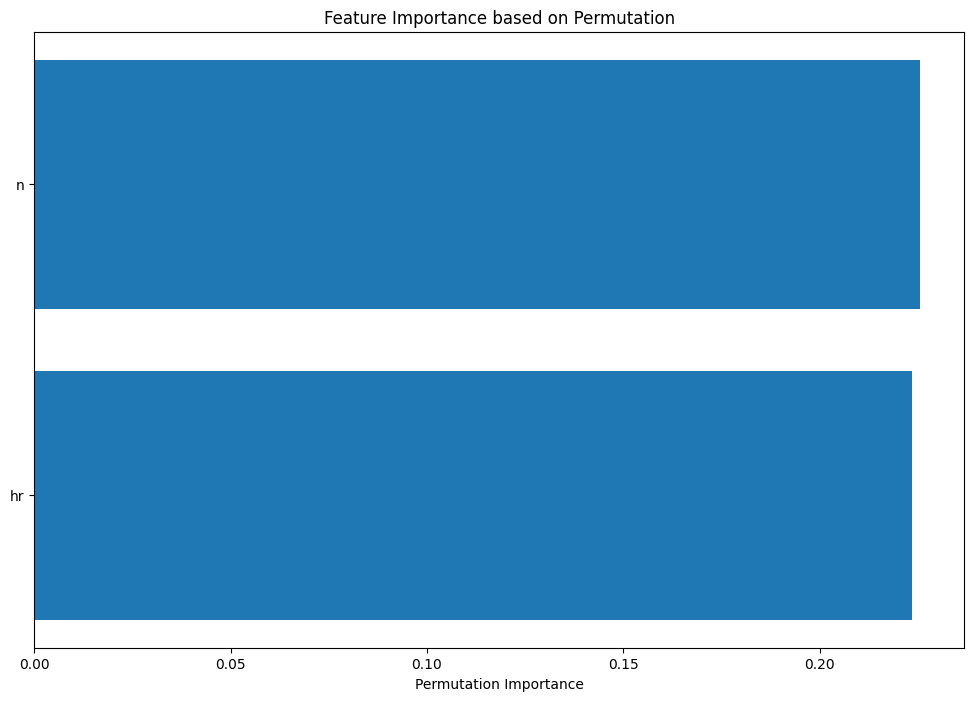

In [38]:
# Sensitivity Analysis
result = permutation_importance(grid_search, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_names = X.columns
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance based on Permutation")
plt.show()